In [1]:
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

In [2]:
!../scripts/copy_data.sh

In [3]:
DATA_PATH = '../data/'

In [4]:
def read(filepath, pred=False):
    dat = pd.read_csv(filepath)
    if not pred:
        dat['buyDate'] = pd.to_datetime(dat['buyDate'])
    return dat

In [5]:
ls -la ../data

total 2416
drwxr-xr-x   6 dsp  staff      204 Jul 13 21:00 ./
drwxr-xr-x  11 dsp  staff      374 Jul  1 16:27 ../
-rw-r--r--@  1 dsp  staff     6148 Jul 13 21:00 .DS_Store
-rw-r--r--@  1 dsp  staff     1749 Sep 17 15:30 Multistock.csv
-rw-r--r--@  1 dsp  staff    46984 Sep 17 15:30 buyStats.csv
-rw-r--r--@  1 dsp  staff  1174245 Sep 16 13:43 sp1950.csv


In [6]:
dat = read(DATA_PATH + 'buyStats.csv')
#new_dat = read(DATA_PATH + 'Multistock.csv', pred=True)
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,stockMACD,stockPmoB,stockPmoW,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days
0,adbe,0,131.72,2017-04-21,149,136.43,1.03576,141.21,1.07205,149.07,...,-0.066,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
1,jblu,0,21.46,2017-04-21,149,21.18,0.98695,22.74,1.05965,23.33,...,0.250,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
2,tsco,0,63.35,2017-04-21,149,57.57,0.90876,55.69,0.87908,51.70,...,-1.254,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
3,ftnt,0,40.16,2017-04-25,145,39.94,0.99452,38.29,0.95344,40.45,...,0.504,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388
4,pac,0,101.15,2017-04-25,145,109.00,1.07761,110.45,1.09194,117.90,...,0.633,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388


In [7]:
def remove_commas(value):
    if type(value) == str:
        return float(value.replace(',', ''))
    else:
        return value
    
dat['freeCashFlow_'] = dat['freeCashFlow_'].apply(lambda x: remove_commas(x))
dat['mCap_'] = dat['mCap_'].apply(lambda x: remove_commas(x))

In [8]:
dat[['stock', 'industry', 'freeCashFlow_', 'mCap_']].tail(10)

,stock,industry,freeCashFlow_,mCap_
180,ato,gasUtilities,-1.871400e+08,NaN
181,mtch,internetSoftwareAndServices,2.243200e+08,NaN
182,nyt,media,1.252900e+08,NaN
183,jd,internetAndDirectMarketingRetail,NaN,6.392000e+10
184,masi,healthCareEquipmentAndSupplies,3.282600e+08,4.450000e+09
185,ndaq,capitalMarkets,5.146800e+08,1.244000e+10
186,tmus,wirelessTelecommunicationServices,1.990000e+09,5.083000e+10
187,dis,media,8.850000e+09,1.576300e+11
188,mtn,hotelsRestaurantsAndLeisure,3.168800e+08,9.100000e+09
189,sbux,hotelsRestaurantsAndLeisure,2.960000e+09,7.904000e+10


In [9]:
dat['industry'] = dat['industry'].apply(lambda x: str(x))
industries = sorted(np.unique(dat['industry']))
industries

['airlines',
 'capitalMarkets',
 'diversifiedTelecommunicationServices',
 'gasUtilities',
 'healthCareEquipmentAndSupplies',
 'hotelsRestaurantsAndLeisure',
 'industrialConglomerates',
 'internetAndDirectMarketingRetail',
 'internetSoftwareAndServices',
 'media',
 'metalsAndMining',
 'nan',
 'software',
 'specialtyRetail',
 'transportationInfrastructure',
 'wirelessTelecommunicationServices']

In [10]:
def one_hot(df):
    X = df.copy()
    X[industries] = pd.get_dummies(X['industry'])
    X[['mfHold', 'mfNone', 'mfNow', 'mfStart']] = pd.get_dummies(X['MF'])
    X = X.drop(['industry', 'MF'], axis=1)
    return X

In [11]:
dat = one_hot(dat)
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,metalsAndMining,nan,software,specialtyRetail,transportationInfrastructure,wirelessTelecommunicationServices,mfHold,mfNone,mfNow,mfStart
0,adbe,0,131.72,2017-04-21,149,136.43,1.03576,141.21,1.07205,149.07,...,0,0,1,0,0,0,0,0,1,0
1,jblu,0,21.46,2017-04-21,149,21.18,0.98695,22.74,1.05965,23.33,...,0,0,0,0,0,0,0,0,1,0
2,tsco,0,63.35,2017-04-21,149,57.57,0.90876,55.69,0.87908,51.70,...,0,0,0,1,0,0,0,0,1,0
3,ftnt,0,40.16,2017-04-25,145,39.94,0.99452,38.29,0.95344,40.45,...,0,0,1,0,0,0,0,0,1,0
4,pac,0,101.15,2017-04-25,145,109.00,1.07761,110.45,1.09194,117.90,...,0,0,0,0,1,0,0,0,1,0


In [12]:
today = datetime.datetime.now()
if today.weekday() == 5:
    today = today - datetime.timedelta(days=1)
if today.weekday() == 6:
    today = today - datetime.timedelta(days=2)
today = str(today).split(' ')[0]
today = pd.to_datetime(today)
today

Timestamp('2017-09-15 00:00:00')

In [13]:
new_dat = dat.loc[dat['buyDate'] > today, :]
dat     = dat.loc[dat['buyDate'] <= today, :]
stocks = new_dat['stock']
new_dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,metalsAndMining,nan,software,specialtyRetail,transportationInfrastructure,wirelessTelecommunicationServices,mfHold,mfNone,mfNow,mfStart
177,mmm,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
178,ccoi,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
179,or,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,1,0,0
180,ato,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
181,mtch,3,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [14]:
def drop_missing(dfs, y_col):
    X = dfs[0].copy()
    # cols
    drop_cols = [col for col in list(X) if type(col[0]) == np.float and col.isnan().all()]
    X = X.drop(drop_cols, axis=1)
    X2 = dfs[1].drop(drop_cols, axis=1)
    return X.loc[np.isnan(dat[y_col]) == False, :], X2

In [15]:
dat, new_dat = drop_missing([dat, new_dat], 'd30Gains')
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,metalsAndMining,nan,software,specialtyRetail,transportationInfrastructure,wirelessTelecommunicationServices,mfHold,mfNone,mfNow,mfStart
0,adbe,0,131.72,2017-04-21,149,136.43,1.03576,141.21,1.07205,149.07,...,0,0,1,0,0,0,0,0,1,0
1,jblu,0,21.46,2017-04-21,149,21.18,0.98695,22.74,1.05965,23.33,...,0,0,0,0,0,0,0,0,1,0
2,tsco,0,63.35,2017-04-21,149,57.57,0.90876,55.69,0.87908,51.70,...,0,0,0,1,0,0,0,0,1,0
3,ftnt,0,40.16,2017-04-25,145,39.94,0.99452,38.29,0.95344,40.45,...,0,0,1,0,0,0,0,0,1,0
4,pac,0,101.15,2017-04-25,145,109.00,1.07761,110.45,1.09194,117.90,...,0,0,0,0,1,0,0,0,1,0


In [16]:
new_dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,metalsAndMining,nan,software,specialtyRetail,transportationInfrastructure,wirelessTelecommunicationServices,mfHold,mfNone,mfNow,mfStart
177,mmm,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
178,ccoi,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
179,or,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,1,0,0
180,ato,0,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
181,mtch,3,NaN,2017-09-18,-1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [17]:
def split_xy(df, y_col, first_X):
    y = df[y_col]
    start_col = list(df).index(first_X)
    X = df.iloc[:, start_col:]
    return X, y

In [18]:
#list(dat)

In [19]:
X, y         = split_xy(dat,     'd30Gains', 'MFRisk')
X_new, y_new = split_xy(new_dat, 'd30Gains', 'MFRisk')

In [20]:
#print(list(X) == list(X_new))
[print('Mismatch:', x, xn) for (x, xn) in zip(list(X), list(X_new)) if x != xn]
#[(x, xn) for (x, xn) in zip(list(X), list(X_new))]

[]

In [21]:
def median_fill(df):
    X = df.copy()

    for col in list(X):
        try:
            X[col][np.isnan(X[col])] = np.nanmedian(X[col])
        except:
            print('Could not fill column', col)
    return X

In [22]:
X = median_fill(X)
X_new = median_fill(X_new)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [23]:
X.shape

(132, 58)

In [24]:
n = X.shape[0]
TRAIN = 0.7
VALIDATE = 0.15
TEST = 0.15
print(
    'Training size:   %.0f\nValidation size: %.0f\nTest       size: %.0f'
    %(TRAIN * n, VALIDATE * n, TEST * n))

Training size:   92
Validation size: 20
Test       size: 20


In [25]:
# Train, Not Train
X_train, X_vt, y_train, y_vt = train_test_split(
    X, y, test_size=VALIDATE + TEST)

# Validate Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_vt, y_vt, test_size=(TEST / (TEST + VALIDATE)))

# Reindex
X_train.index = range(len(y_train))
y_train.index = range(len(y_train))

X_valid.index = range(len(y_valid))
y_valid.index = range(len(y_valid))

X_test.index = range(len(y_test))
y_test.index = range(len(y_test))
y_test = y_test.values.reshape(-1, 1)

In [26]:
#X.head()

In [27]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(X_new.shape)

(92, 58)
(20, 58)
(20, 58)
(13, 58)


In [28]:
# WHILE DATA SET IS SMALL, restrict values in new data to the range seen 
# in training data
if X_test.shape[0] < 100:
    for col in list(X_train):
        if col not in ['spVal', 'days']:
            mn, mx = np.min(X_train[col]), np.max(X_train[col])
            X_new[col][X_new[col] < mn] = mn
            X_new[col][X_new[col] > mx] = mx

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
remove_empties = []

for col in list(X_train):
    try:
        if np.isnan(X_train[col]).any():
            remove_empties.append(col)
            print(col)
    except:
        print('\tCould not check', col)
        
X_train = X_train.drop(remove_empties, axis=1)
X_valid = X_valid.drop(remove_empties, axis=1)
X_test  = X_test.drop(remove_empties, axis=1)
X_new   = X_new.drop(remove_empties, axis=1)

mCap_
mCap
pE_
pB_
revG5_
freeCashFlow_
grossMarQ_
opMarQ_
roaTTM_
roiQ_
roiTTM_
totDEq_


In [32]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_new  = scaler.transform(X_new)

## Create Neural Net

In [33]:
# Create a fully-connected layer of neurons using dropout regularization
def make_drop_layer(in_layer,
                    n_out,
                    activation,
                    kernel_initializer,
                    dropout_rate,
                    training):
    h = tf.layers.dense(in_layer,
                        n_out,
                        activation=activation,
                        kernel_initializer=kernel_initializer)
    h_drop = tf.layers.dropout(h, rate=dropout_rate, training=training)
    return h_drop

In [34]:
X_train.shape

(92, 46)

In [35]:
# Run only before first model is executed
best_error_so_far = np.Inf

In [223]:
# Rerun models from here
N, D = X_train.shape

# Hyperparmeters to tune
DROPOUT_RATE = 0
n_neurons = [D, D, D, D, 1]

# Progrmmed Learning with Decay
ETA = 0.05 # Learning rate
DECAY_STEPS = 100  # eta updates after this many epochs
DECAY_RATE = 0.99  # factor to change eta by

batch_size = 30
epochs = 10000

In [224]:
ops.reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [225]:
X_drop = tf.layers.dropout(X, DROPOUT_RATE, training=training)

In [226]:
with tf.name_scope('dnn'):
    # He intialization randomly initalizes weigths and their variances in 
    # a way that minimizes the likelihood of vanishing/exploding gradients
    he_init = tf.contrib.layers.variance_scaling_initializer()
    current_in = X

    for layer in range(1, len(n_neurons)):
        current_in = make_drop_layer(
            in_layer=current_in,
            n_out=n_neurons[layer],
            activation=tf.nn.tanh if (layer + 1) < len(n_neurons) else None,
            kernel_initializer=he_init,
            dropout_rate=DROPOUT_RATE,
            training=training)

    preds = tf.nn.relu(current_in)

In [227]:
with tf.name_scope('cost'):
    cost = tf.reduce_sum(tf.pow(preds - y, 2)) # SSE

In [228]:
with tf.name_scope('train'):
    eta0 = ETA # initial learning rate
    decay_steps = DECAY_STEPS  # eta updates after this many epochs
    decay_rate = DECAY_RATE    # factor to change eta by
    global_step = tf.Variable(0, trainable=False, name='global_step')
    eta = tf.train.exponential_decay(
        eta0, global_step, decay_steps, decay_rate, name='eta')
    optimizer = tf.train.AdamOptimizer(eta).minimize(
        cost, global_step=global_step)

In [229]:
train_err = []
valid_err = []
saver = tf.train.Saver()

In [230]:
# TODO: add batch regularization

In [231]:
with tf.Session() as s:
    s.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        idxs = np.random.permutation(range(N))
        n_batches = len(idxs) // batch_size

        for batch in range(n_batches):
            idx = idxs[batch * batch_size : (batch + 1) * batch_size]
            s.run(optimizer, feed_dict={training: True,
                                        X: X_train[idx, :],
                                        y: y_train[idx]})
        err_train = cost.eval(feed_dict={X: X_train[idx, :],
                                         y: y_train[idx]}) 
        err_valid = (cost.eval(feed_dict={X: X_valid, y: y_valid}))

        # Convert from SSE to MSE so train and valid can be compared 
        err_train /= y_train.shape[0]
        err_valid /= y_valid.shape[0]

        train_err.append(err_train)
        valid_err.append(err_valid)

        if epoch % 100 == 0:
            print(
                '%4d: Train error: %.5f\tValidation error: %.5f'
                %(epoch, err_train, err_valid))

    save_path = saver.save(s, './nn_mod.ckpt')

   0: Train error: 5.53262	Validation error: 12.07603
 100: Train error: 0.12162	Validation error: 0.36813
 200: Train error: 0.16421	Validation error: 0.20397
 300: Train error: 0.11022	Validation error: 0.29643
 400: Train error: 0.08660	Validation error: 0.19508
 500: Train error: 0.09310	Validation error: 0.20038
 600: Train error: 0.16383	Validation error: 0.27854
 700: Train error: 0.05385	Validation error: 0.30019
 800: Train error: 0.06616	Validation error: 0.21991
 900: Train error: 0.05300	Validation error: 0.24083
1000: Train error: 0.08472	Validation error: 0.33143
1100: Train error: 0.07479	Validation error: 0.20134
1200: Train error: 0.16917	Validation error: 0.51948
1300: Train error: 0.19473	Validation error: 0.31108
1400: Train error: 0.10894	Validation error: 0.33527
1500: Train error: 0.07445	Validation error: 0.24233
1600: Train error: 0.15212	Validation error: 0.35680
1700: Train error: 0.10960	Validation error: 0.22255
1800: Train error: 0.17596	Validation error: 

In [232]:
appx_validation_error = np.mean(valid_err[-(10 * N):])
print('Previous Best:', best_error_so_far)
print('This run:     ', appx_validation_error)

Previous Best: 0.228177981506
This run:      0.226791441622


In [233]:
if appx_validation_error < best_error_so_far:
    best_error_so_far = appx_validation_error
    print('New Best Model Found!\nHyperparameters:\n' + ('-' * 70))
    hyperparams = {
        'best_error_so_far': appx_validation_error,
        'best_droupout': DROPOUT_RATE,
        'best_architecture': n_neurons,
        'best_eta': ETA,
        'best_decay_steps': DECAY_STEPS,
        'best_decay_rate': DECAY_RATE}
for k, v in hyperparams.items():
    print('%17s: %s' %(k, str(v)))

New Best Model Found!
Hyperparameters:
----------------------------------------------------------------------
best_error_so_far: 0.226791441622
    best_droupout: 0
best_architecture: [46, 46, 46, 46, 1]
         best_eta: 0.05
 best_decay_steps: 100
  best_decay_rate: 0.99


In [234]:
# TO DO: Search over hyperparameter space

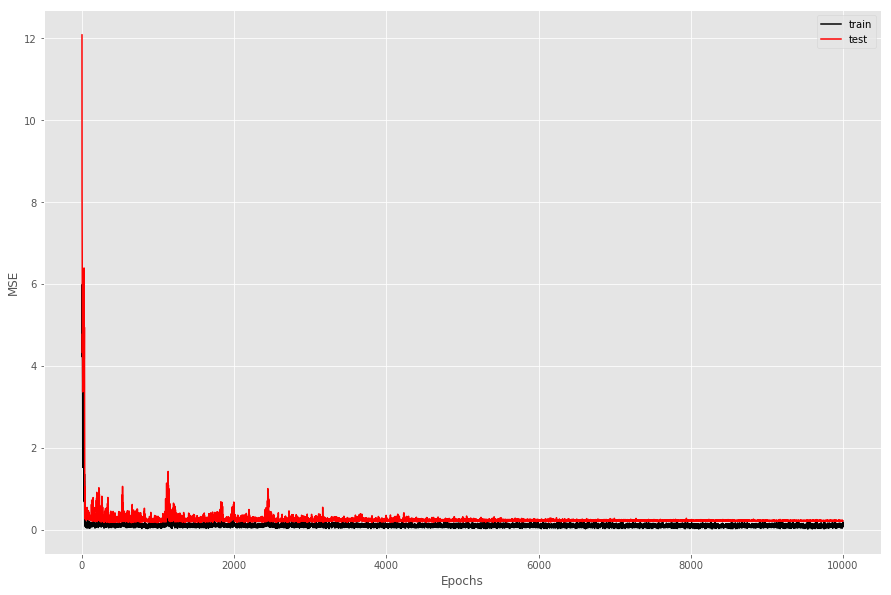

In [235]:
plt.plot(train_err, 'k-', label='train');
plt.plot(valid_err, 'r-', label='test');
plt.legend(loc='best');
plt.xlabel('Epochs');
plt.ylabel('MSE');

In [236]:
s = tf.Session()
saver = tf.train.Saver()
saver.restore(s, './nn_mod.ckpt')
test_preds = s.run(preds, feed_dict={X: X_test})

In [237]:
test_err = ((test_preds - y_test) ** 2).sum() / y_test.shape[0]
test_err

0.0037709678383203993

In [238]:
new_preds = s.run(preds, feed_dict={X: X_new})

In [239]:
final_out = []
for stock, pred in zip(stocks, new_preds.reshape(new_preds.shape[0])):
    final_out.append([stock, pred])
    
out = pd.DataFrame(columns=['Stock', 'Prediction'], data=final_out)
out['LowerBound'] = out['Prediction'] - 2*test_err
out['UpperBound'] = out['Prediction'] + 2*test_err
out = out.sort_values('Prediction', ascending=False)
out.head(len(stocks))

,Stock,Prediction,LowerBound,UpperBound
10,dis,1.016620,1.009078,1.024162
2,or,1.015039,1.007497,1.022581
1,ccoi,1.011817,1.004275,1.019359
3,ato,1.008962,1.001420,1.016504
7,masi,1.008306,1.000764,1.015847
11,mtn,1.007814,1.000272,1.015356
0,mmm,1.007800,1.000259,1.015342
5,nyt,1.007315,0.999773,1.014857
4,mtch,1.006594,0.999052,1.014136
6,jd,1.005192,0.997650,1.012734
